In [4]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import *
import scqubits
import colorednoise as cn

In [17]:
from scipy.optimize import golden
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        self.get_projectors()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)

        
    def get_indices(self, dims):
        """
        Convert a list of 2D indices to 1D indices based on given dimensions.
        
        Args:
            dims: List of two integers [N,K] specifying the dimensions to include
                 N is number of cavity states
                 K is number of SNAIL states
                 
        Returns:
            List of 1D indices corresponding to the 2D indices
        """
        N, K = dims
        indices_2d = []
        indices_1d = []
        
        # Generate all 2D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.cdim):
                # Only add indices that are outside the truncation
                if n >= N or k >= K:
                    indices_2d.append(f"{n}{k}")
                    # Convert to 1D index using n*cdim + k
                    idx = n*self.cdim + k
                    indices_1d.append(idx)

        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, np.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = np.delete(np.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf, noise = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        self.Hs = Hs
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control,noise = composite_sys(squid,cavity,noise)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()
        self.U1 = U
        self.Ud1 = Ud

        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        self.noise = noise

        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmaxc = np.kron(np.eye(self.sdim), cavity_sigmax)
        self.sigmaxc = self.truncate_matrix(sigmaxc, self.trunc)
        squid_sigmax = np.zeros((self.sdim, self.sdim))
        squid_sigmax[0,1] = 1
        squid_sigmax[1,0] = 1
        sigmaxs = np.kron(squid_sigmax, np.eye(self.cdim))
        self.sigmaxs = self.truncate_matrix(sigmaxs, self.trunc)
    
    
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf,noise = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control,noise = composite_sys(squid,cavity,noise)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()

        self.H_per = H
        self.H_control_per = H_control

        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]

    def get_noise_operator(self):
        
        # s = self.annihilation(self.sdim)
        # sd = self.creation(self.sdim)
        # ic = np.identity(self.cdim)
        # self.noise = self.truncate_matrix(np.kron(sd@s, ic), self.trunc)

        self.noise = self.Ud1@self.noise@self.U1
        
        self.noise = self.truncate_matrix(self.noise, self.trunc)
        self.H = self.Ud1@self.H@self.U1
        self.H = self.truncate_matrix(self.H, self.trunc)
        self.H_control = self.Ud1@self.H_control@self.U1
        self.H_control = self.truncate_matrix(self.H_control, self.trunc)
    
    def get_projectors(self):
        trunc = self.trunc
        truncated_total_dim = trunc[-1]*trunc[-2]
        projectors = []
        for i in range(truncated_total_dim):
            projector = qt.basis(truncated_total_dim, i)*qt.basis(truncated_total_dim, i).dag()

            projectors.append(projector)
        self.projectors = projectors
        

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    
    def optimal_omegad(self, A):
        # Create a wrapper function that ensures we return a Python float
        def calculate_dr_wrapper(A, omega_d):
            result = self.calculate_dr_exact(A, omega_d)
            return float(result)

        # Define objective function
        def objective(omega_d):
            return calculate_dr_wrapper(A, omega_d)

        # Try different bracketing values until we find ones that work
        omega_min = 5.8 * 2 * np.pi
        omega_max = 6.4 * 2 * np.pi
        n_points = 10
        omega_range = np.linspace(omega_min, omega_max, n_points)
        
        # Find minimum point among test points
        rates = [objective(omega) for omega in omega_range]
        min_idx = np.argmin(rates)
        
        if min_idx == 0 or min_idx == len(omega_range)-1:
            # If minimum is at edge, return that value
            optimal_omega = omega_range[min_idx]
            min_rate = rates[min_idx]
        else:
            # Use points around minimum for bracketing
            xa = omega_range[min_idx-1]
            xb = omega_range[min_idx]
            xc = omega_range[min_idx+1]
            
            # Use golden section search for optimization
            optimal_omega = golden(objective, brack=(xa, xb, xc))
            min_rate = objective(optimal_omega)
        
        return optimal_omega/2/np.pi, min_rate
    

    def calculate_floquet_U(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        self.sigmax_dressed = Ud@self.sigmaxc@U
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        return initial_state, self.sigmax_dressed,
    
    def calculate_floquet_U_test(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        noise = Ud@self.noise@U
        H = Ud@self.H@U
        H_control = Ud@self.H_control@U
        return noise, H, H_control



In [18]:
def generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white):
    """
    Generate N realizations of 1/f^alpha noise with T samples each.
    Returns array of shape (N, T).
    """
    N = int(sample_rate * t_max) + 1
    if white == True:
        # Generate white noise
        alpha = 0
    if white == False:
        # Generate 1/f^alpha noise
        alpha = 1
    
    return cn.powerlaw_psd_gaussian(alpha, N, fmin=f0)*np.sqrt(relative_PSD_strength * sample_rate)

In [19]:
from joblib import Parallel, delayed


def _single_trajectory(idx, phi_ex, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, H_control, A, optimal_omega, noise,ex_ops):
    trajectory = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    (np.cos(phi_ex*np.pi)*(np.cos(trajectory*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajectory*np.pi))
    t_list = np.linspace(0, t_max, int(sample_rate*t_max) + 1)
    args = {'w': optimal_omega}
    noise_op = qt.Qobj(noise)
    H_tot = [H0, [noise_op, trajectory], [H_control, lambda t, args: A * np.cos(args['w'] * t)]]
    options = {'nsteps': 100000, 'atol': 1e-13, 'rtol': 1e-13}  # Increase nsteps to handle the integration
    result = qt.sesolve(H_tot, init_state, t_list, e_ops=ex_ops, args=args, options = options)
    return t_list, result.expect

def monte_carlo_squid(phi_ex, H0, init_state, H_control, A, optimal_omega, noise,
                    num_realizations=1000, sample_rate=1, t_max=200, 
                     relative_PSD_strength=(1e-3)**2, f0=1e-2, white=False, ex_ops=None, n_jobs=60):
    N = int(sample_rate*t_max) + 1
    trajectories_list = np.zeros((num_realizations, N))
    
    # Sequential computation for debugging
    # results = []
    # for idx in range(num_realizations):
    #     result = _single_trajectory(idx, sample_rate, t_max, relative_PSD_strength, f0, white, H0, init_state, H_control, A, optimal_omega, noise,ex_ops)
    #     results.append(result)
        
    # Parallel computation for performance
    results = Parallel(n_jobs=n_jobs)(
        delayed(_single_trajectory)(
            idx, phi_ex, sample_rate, t_max, relative_PSD_strength, f0, white,
            H0, init_state, H_control, A, optimal_omega, noise, ex_ops
        ) for idx in range(num_realizations)
    )
    
    # Unpack results
    # Get shape of expectation values from first result
    expect_shape = np.array(results[0][1]).shape
    Xtraj_list = np.zeros((num_realizations,) + expect_shape)
    
    for idx, (  t_list,expect) in enumerate(results):
        Xtraj_list[idx] = np.array(expect)
    
    
    return t_list, Xtraj_list

In [20]:
# Set parameters
sample_rate = 1                    # per ns
t_max = 2e1                        # in ns
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (ns^-2)/sample_rate
f0 = 1e-4                          # sets cut-off for low-pass filtered noise, in ns^-1
num_realizations = 100          # Number of Monte-Carlo trajectories

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 3)).unit()
sigmax = qt.Qobj(sc.sigmaxs)
A = 0.
omega = 10*2*np.pi
noise = sc.noise
projectors = sc.projectors
# Combine existing projectors and sigmax into single list
ex_ops = [*projectors, sigmax]

t_list, Xtraj_list_lowfreq, = \
monte_carlo_squid(phi_ex, H0, init_state, H_control, A, 6*2*np.pi, noise,\
                    num_realizations=num_realizations, sample_rate=sample_rate, t_max=t_max, \
                     relative_PSD_strength=relative_PSD_strength, f0=f0, white=False, ex_ops=ex_ops, n_jobs=60)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)



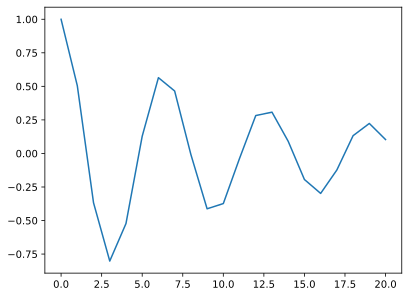

In [21]:
plt.plot(mean_Xtraj_lowfreq[-1])

Fitted gamma: 0.08087821116921258
Fitted w: 38.68786577428807


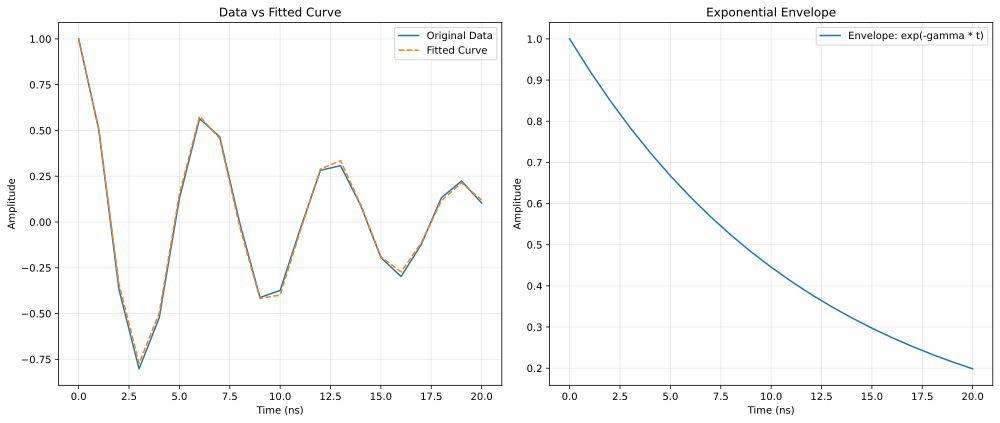

In [22]:
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 6.16 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, mean_Xtraj_lowfreq[-1], p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")
# Plot the original data and the fitted curve in the first subplot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(t_list, mean_Xtraj_lowfreq[-1], label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Data vs Fitted Curve")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot the exponential envelope in the second subplot
plt.subplot(1, 2, 2)
plt.plot(t_list, np.exp(-gamma_fit * t_list), label="Envelope: exp(-gamma * t)")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.title("Exponential Envelope")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
vals = np.diag(noise - noise[0][0])
vals[1]
vals[3]

np.complex128(24.05592033059486+7.346839692639297e-40j)

In [24]:
# Set parameters
sample_rate = 1                    # per ns
t_max = 1e3                        # in ns
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (ns^-2)/sample_rate
f0 = 1e-4                          # sets cut-off for low-pass filtered noise, in ns^-1
num_realizations = 50           # Number of Monte-Carlo trajectories

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
init_state = (qt.basis(sc.total_dim, 0) + qt.basis(sc.total_dim, 1)).unit()
sigmax = qt.Qobj(sc.sigmaxc)
A = 0.
omega = 10*2*np.pi
noise = sc.noise.copy()
np.fill_diagonal(noise, np.diag(noise) - noise[0,0])
projectors = sc.projectors
# Combine existing projectors and sigmax into single list
ex_ops = [*projectors, sigmax]

t_list, Xtraj_list_lowfreq = \
monte_carlo_squid(phi_ex, H0, init_state, H_control, A, 6*2*np.pi, noise,\
                    num_realizations=num_realizations, sample_rate=sample_rate, t_max=t_max, \
                     relative_PSD_strength=relative_PSD_strength, f0=f0, white=False, ex_ops=ex_ops, n_jobs=60)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)



Fitted gamma: 0.0001733679940570744
Fitted w: 32.76600023960872


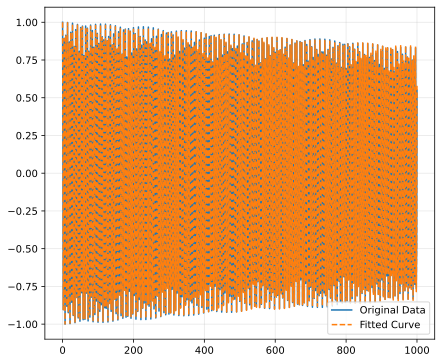

In [25]:
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, np.mean(Xtraj_list_lowfreq, axis=0)[-1], p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, np.mean(Xtraj_list_lowfreq, axis=0)[-1], label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
# Set parameters
sample_rate = 1                    # per ns
t_max = 1e3                        # in ns
relative_PSD_strength = 0*(1e-2)**2    # sets frequency noise PSD at zero frequency, in (ns^-2)/sample_rate
f0 = 1e-4                          # sets cut-off for low-pass filtered noise, in ns^-1
num_realizations = 50           # Number of Monte-Carlo trajectories

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 1e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

In [27]:
initial_state, sigmax = sc.calculate_floquet_U(A, optimal_omega)
initial_state = qt.Qobj(initial_state)
sigmax = qt.Qobj(sigmax)
noise = sc.noise
projectors = sc.projectors
# Combine existing projectors and sigmax into single list
ex_ops = [*projectors, sigmax]

t_list, Xtraj_list_lowfreq= monte_carlo_squid(phi_ex, H0, init_state, H_control, A, optimal_omega, noise,\
                    num_realizations=num_realizations, sample_rate=sample_rate, t_max=t_max, \
                     relative_PSD_strength=relative_PSD_strength, f0=f0, white=False, ex_ops=ex_ops, n_jobs=60)

mean_Xtraj_lowfreq = np.mean(Xtraj_list_lowfreq, axis=0)
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)


In [28]:
sigmax

Quantum object: dims=[[15], [15]], shape=(15, 15), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-2.14081610e-04+2.81329472e-23j  9.98818917e-01-4.28286210e-03j
   1.51147953e-04-2.23655784e-06j -3.85960135e-06+1.10552050e-06j
   2.90166932e-02-3.86346598e-02j -6.76389946e-06-1.16412892e-05j
  -2.20298405e-05+5.29985941e-07j -2.19633935e-03-1.59734739e-03j
  -6.98325168e-07+4.66760903e-07j  2.42835745e-06+8.68867874e-06j
  -5.42787535e-06+2.13396614e-05j -3.28251949e-08-1.28507412e-07j
   1.06303824e-07+2.84611704e-07j -3.71075500e-07-3.33843875e-07j
  -6.55930283e-09-3.37254695e-09j]
 [ 9.98818917e-01+4.28286210e-03j  2.13892079e-04-8.44192801e-23j
  -7.53185350e-10-7.45349187e-09j -2.90560092e-02+3.86525524e-02j
   3.27975369e-06-3.11442606e-07j  1.15248608e-09-3.74591313e-08j
   1.24508702e-03+1.61698047e-03j  2.15882433e-05-8.24698385e-07j
   8.10403116e-09-2.23568363e-09j -1.53375920e-05+4.75186132e-06j
  -9.04362557e-09-7.18357970e-06j -1.76488454e-09+1.02801009e-09j
   2.6

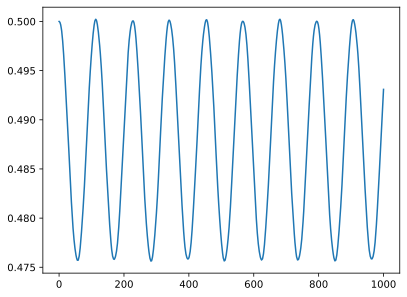

In [29]:
plt.plot(mean_Xtraj_lowfreq[1])

Fitted gamma: 2.8843587303784264e-05
Fitted w: 32.765755730992275


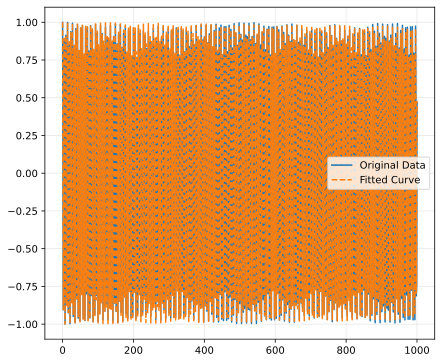

In [30]:
std_dev_trajectory = np.std(Xtraj_list_lowfreq, axis=0)
from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0.01, 5.2 * 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, np.mean(Xtraj_list_lowfreq, axis=0)[-1], p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, np.mean(Xtraj_list_lowfreq, axis=0)[-1], label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()